# Customer Churn Analysis

This workbook is a code demo that implements a custom Customer Retention Analysis class that has a number of helpful built in methods to generate customer churn insights frequently used for marketing analytics to understand the growth and change of an organisation's customer base (new vs retained vs lost)

This woksbook is accompanied by a blog article at "Analyzing Customer Retention Via Cohort Analysis" https://medium.com/p/1f381748e555

In [1]:
#Load the relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1.Creating The Custom Class

In [2]:
class CustRetAnalysisObj:
    def __init__(self, trx_dataframe,order_id,transaction_id,customer_id,timestamp,monetary_value,granularity="d"):
        self.trx_dataframe = trx_dataframe #input dataframe
        self.order_id = order_id #unique number for each order which may have multiple transactions within a single order
        self.transaction_id = transaction_id #unique number for each trx (i.e order line item) 
        self.customer_id = customer_id
        self.timestamp = timestamp #transaction timestamp
        self.monetary_value= monetary_value 
        self.granularity= granularity #D,W,M,MS,Q,QS,Y,YS

    def aggregate_by_time(self): #this function returns a dataframe aggregated by time granularity selected 
        df_monetary_value=self.trx_dataframe[[self.timestamp,self.customer_id,self.monetary_value]].groupby([
                     pd.Grouper(key=self.timestamp, axis=0,freq=self.granularity),
                     self.customer_id
                   ]).sum()
        df_monetary_value=df_monetary_value.reset_index()
        
        df_invoice_count=self.trx_dataframe[[self.timestamp,self.order_id,self.customer_id]].groupby([
                     pd.Grouper(key=self.timestamp, axis=0,freq=self.granularity),
                     self.customer_id
                   ]).nunique()
        df_invoice_count=df_invoice_count.reset_index()
    
        df_trxline_count=self.trx_dataframe[[self.timestamp,self.transaction_id,self.customer_id]].groupby([
                     pd.Grouper(key=self.timestamp, axis=0,freq=self.granularity),
                     self.customer_id
                   ]).count()
        df_trxline_count=df_trxline_count.reset_index()
    
        df=df_monetary_value.merge(df_invoice_count, on=[self.timestamp,self.customer_id])
        df=df.merge(df_trxline_count, on=[self.timestamp,self.customer_id])
    
        df=df.rename(columns = {self.order_id:'Unique Count Of '+self.order_id,self.transaction_id:'Count of '+self.transaction_id})
    
        return df

    def spend_by_period(self):
        return self.aggregate_by_time()[[self.timestamp,self.monetary_value]].groupby([self.timestamp]).sum()
        
    def new_joiner_by_period(self): #this function returns the no of new joiners by trx date against time granularity selected 
        customer_earliest_order_period=pd.DataFrame(self.aggregate_by_time().groupby([self.customer_id])[self.timestamp].min())
        customer_earliest_order_period.rename(columns = {self.timestamp:'CohortJoinPeriod'}, inplace = True)
        customer_earliest_order_period=customer_earliest_order_period.reset_index()

        customer_joining_by_period=pd.DataFrame(customer_earliest_order_period.groupby([
                         pd.Grouper(key='CohortJoinPeriod', axis=0, freq=self.granularity) #First Order Date/Time Period
                       ])[self.customer_id].count())
        
        customer_joining_by_period.rename(columns = {self.customer_id:"Total Count Of New Joiner "+self.customer_id}, inplace = True)
        
        return customer_joining_by_period

    def total_active_customers_by_period(self):
        data_agg_by_period=self.aggregate_by_time().merge(self.customer_by_earliest_and_latest_transaction(), on = self.customer_id, how = 'left')
        data_agg_by_period=data_agg_by_period.merge(self.cohort_time_step_mapping(), on =[self.timestamp,'CohortJoinPeriod'])
        
        #count monthly active customers from each cohort
        grouping = data_agg_by_period.groupby([self.timestamp,'CohortJoinPeriod','CohortTimeStep'])
        cohort_data = grouping[self.customer_id].apply(pd.Series.nunique)
        cohort_data = cohort_data.reset_index()
        TotalCountActiveCustomers=pd.DataFrame(cohort_data.groupby(self.timestamp)[self.customer_id].sum())
        TotalCountActiveCustomers.rename(columns = {self.customer_id:"Total Count Of Active "+self.customer_id}, inplace = True)

        NewJoinerCountCustomers=self.new_joiner_by_period()
        NewJoinerCountCustomers.index.names = [self.timestamp]
        NewJoinerCountCustomers.rename(columns = {self.customer_id:"Total Count Of New Joiner "+self.customer_id}, inplace = True)
        
        TotalCountActiveCustomer=TotalCountActiveCustomers.join(NewJoinerCountCustomers)
        
        TotalCountActiveCustomer["Total Count Of Retained "+self.customer_id]=(
            TotalCountActiveCustomer["Total Count Of Active "+self.customer_id]-
            TotalCountActiveCustomer["Total Count Of New Joiner "+self.customer_id])

        return TotalCountActiveCustomer

    def customer_by_earliest_and_latest_transaction(self): 
        customer_latest_order_period=pd.DataFrame(self.aggregate_by_time().groupby([self.customer_id])[self.timestamp].max())
        customer_latest_order_period.rename(columns = {self.timestamp:'Last Recent Order Period'}, inplace = True)
        customer_latest_order_period=customer_latest_order_period.reset_index()

        customer_earliest_order_period=pd.DataFrame(self.aggregate_by_time().groupby([self.customer_id])[self.timestamp].min())
        customer_earliest_order_period.rename(columns = {self.timestamp:'CohortJoinPeriod'}, inplace = True)
        customer_earliest_order_period=customer_earliest_order_period.reset_index()

        df_merge = customer_earliest_order_period.merge(customer_latest_order_period, on = self.customer_id, how = 'left')
        
        return df_merge

    def cohort_time_step_mapping(self):
        # Define the date range
        start_date = self.aggregate_by_time()[self.timestamp].min()
        end_date = self.aggregate_by_time()[self.timestamp].max()
        frequency = self.granularity 
        
        date_range = pd.date_range(start=start_date, end=end_date, freq=frequency)
        
        timesteps = pd.DataFrame(index=date_range)
        timesteps = timesteps.reset_index()
        timesteps = timesteps.reset_index()
        timesteps.columns = ['CohortTimeStep', self.timestamp]
        timestep_mapping=pd.DataFrame()
        
        for i in range(0,len(timesteps)):
            timestep_temp=timesteps.copy()
            timestep_temp["CohortJoinPeriod"]=timesteps[self.timestamp][i]
            timestep_temp["CohortTimeStep"]=timesteps["CohortTimeStep"]
            timestep_temp["CohortTimeStep"]=timestep_temp["CohortTimeStep"].shift(i)
            timestep_mapping=pd.concat([timestep_mapping, timestep_temp], 
                          ignore_index = True)

        return timestep_mapping

    def cohort_by_acquisition_period(self,selectedmode="pct"):

        data_agg_by_period=self.aggregate_by_time().merge(self.customer_by_earliest_and_latest_transaction(), on = self.customer_id, how = 'left')
        data_agg_by_period=data_agg_by_period.merge(self.cohort_time_step_mapping(), on =[self.timestamp,'CohortJoinPeriod'])

        #count monthly active customers from each cohort
        grouping = data_agg_by_period.groupby([self.timestamp,'CohortJoinPeriod','CohortTimeStep'])
        cohort_data = grouping[self.customer_id].apply(pd.Series.nunique)
        cohort_data = cohort_data.reset_index()
        cohort_counts = cohort_data.pivot_table(index='CohortJoinPeriod', columns = 'CohortTimeStep', values=self.customer_id)
        
        #Retention in percentages
        cohort_sizes = cohort_counts.iloc[:,0]
        retention = cohort_counts.divide(cohort_sizes, axis=0)
        retention = retention.round(2) * 100

        cohort_spend= grouping[self.monetary_value].apply(pd.Series.sum).reset_index().round().pivot_table(index='CohortJoinPeriod', columns = 'CohortTimeStep', values=self.monetary_value)

        if selectedmode=="pct":
            return retention
        elif selectedmode=="abs":
            return cohort_counts
        elif selectedmode=="spend":
            return cohort_spend
        elif selectedmode=="cohort_data":
            return cohort_data

    def overall_retention_by_timestep(self):
        OverallRetentionRate=pd.DataFrame(self.cohort_by_acquisition_period("abs").sum())
        OverallRetentionRate["Retention Rate %"]=round(OverallRetentionRate[0]/OverallRetentionRate[0].max()*100,2)
        OverallRetentionRate.rename(columns = {0:'Retained Customers By TimeStep'}, inplace = True)
        return OverallRetentionRate

    def cohort_by_customer_attr(self,df_customer_attr,customer_attr,selectedmode="pct"):

        data_agg_by_period=self.aggregate_by_time().merge(self.customer_by_earliest_and_latest_transaction(), on = self.customer_id, how = 'left')
        data_agg_by_period=data_agg_by_period.merge(self.cohort_time_step_mapping(), on =[self.timestamp,'CohortJoinPeriod'])
        data_agg_by_period=data_agg_by_period.merge(df_customer_attr, on =[self.customer_id])
        
        #count active customers from each criteria cohort
        grouping = data_agg_by_period.groupby([customer_attr,'CohortTimeStep'])
        cohort_data = grouping[self.customer_id].apply(pd.Series.nunique)
        cohort_data = cohort_data.reset_index()
        cohort_counts = cohort_data.pivot_table(index=customer_attr, columns = 'CohortTimeStep', values=self.customer_id)
        
        #Retention in percentages
        cohort_sizes = cohort_counts.iloc[:,0]
        retention = cohort_counts.divide(cohort_sizes, axis=0)
        retention = retention.round(2) * 100

        cohort_spend= grouping[self.monetary_value].apply(pd.Series.sum).reset_index().round().pivot_table(index=customer_attr, columns = 'CohortTimeStep', values=self.monetary_value)

        if selectedmode=="pct":
            return retention
        elif selectedmode=="abs":
            return cohort_counts
        elif selectedmode=="spend":
            return cohort_spend

    def cohort_by_acquisition_period_by_inactive_period(self,durationInDays,selectedmode="pct"):

        overallCustomerActiveByCohortTimeStep=pd.DataFrame()
        df_merge=self.customer_by_earliest_and_latest_transaction()
        df_merge["Customer Expiry Period"]=df_merge["Last Recent Order Period"]+pd.Timedelta(days=durationInDays)

        start_date = self.aggregate_by_time()[self.timestamp].min()
        end_date = self.aggregate_by_time()[self.timestamp].max()
        frequency = self.granularity 
        
        date_range = pd.date_range(start=start_date, end=end_date, freq=frequency)
        
        for customer in df_merge[self.customer_id].to_list():
            indivCustomertempDF=pd.DataFrame()
            
            CustomerCohortJoinPeriod=df_merge[df_merge[self.customer_id]== customer]['CohortJoinPeriod'].values[0]
            CustomerLastRecentOrderPeriod=df_merge[df_merge[self.customer_id]==customer]["Last Recent Order Period"].values[0]
            CustomerExpiryPeriod=df_merge[df_merge[self.customer_id]==customer]["Customer Expiry Period"].values[0]
            
            temp_list=[]
            
            for i in date_range:
                if CustomerCohortJoinPeriod<=i:
                    if CustomerExpiryPeriod>=i :
                        temp_list.append(1)
                    elif CustomerExpiryPeriod<i :
                        temp_list.append(0)
                else:
                    None  
                        
            indivCustomertempDF["Active"]=temp_list
            indivCustomertempDF[self.customer_id]=customer
            indivCustomertempDF["CohortJoinPeriod"]=CustomerCohortJoinPeriod
            indivCustomertempDF.index.name = 'CohortTimeStep'
            indivCustomertempDF=indivCustomertempDF.reset_index()
            
            overallCustomerActiveByCohortTimeStep=pd.concat([overallCustomerActiveByCohortTimeStep, indivCustomertempDF], 
                              ignore_index = True)
            
            overallCustomerActiveByCohortTimeStep

        #count monthly active customers from each cohort
        grouping = overallCustomerActiveByCohortTimeStep.groupby(['CohortJoinPeriod','CohortTimeStep'])
        cohort_data = grouping['Active'].apply(pd.Series.sum)
        cohort_data = cohort_data.reset_index()
        cohort_counts = cohort_data.pivot_table(index='CohortJoinPeriod', columns = 'CohortTimeStep', values='Active')

        #Retention in percentages
        cohort_sizes = cohort_counts.iloc[:,0]
        retention = cohort_counts.divide(cohort_sizes, axis=0)
        retention = retention.round(2) * 100

        # cohort_spend= grouping[self.monetary_value].apply(pd.Series.sum).reset_index().round().pivot_table(index='CohortJoinPeriod', columns = 'CohortTimeStep', values=self.monetary_value)

        if selectedmode=="pct":
            return retention
        elif selectedmode=="abs":
            return cohort_counts
        elif selectedmode=="ExpiryDateByCustomer":
            return df_merge
            
    def cohort_by_customer_attr_by_inactive_period(self,df_customer_attr,customer_attr,durationInDays,selectedmode="pct"):

        overallCustomerActiveByCohortTimeStep=pd.DataFrame()
        df_merge=self.customer_by_earliest_and_latest_transaction()
        df_merge["Customer Expiry Period"]=df_merge["Last Recent Order Period"]+pd.Timedelta(days=durationInDays)
        df_merge=df_merge.merge(df_customer_attr, on =[self.customer_id])
        
        start_date = self.aggregate_by_time()[self.timestamp].min()
        end_date = self.aggregate_by_time()[self.timestamp].max()
        frequency = self.granularity 
                
        date_range = pd.date_range(start=start_date, end=end_date, freq=frequency)
                
        for customer in df_merge[self.customer_id].to_list():
            indivCustomertempDF=pd.DataFrame()
                    
            CustomerCohortJoinPeriod=df_merge[df_merge[self.customer_id]== customer]['CohortJoinPeriod'].values[0]
            Customer_Attribute=df_merge[df_merge[self.customer_id]== customer][customer_attr].values[0]
            CustomerLastRecentOrderPeriod=df_merge[df_merge[self.customer_id]==customer]["Last Recent Order Period"].values[0]
            CustomerExpiryPeriod=df_merge[df_merge[self.customer_id]==customer]["Customer Expiry Period"].values[0]
                    
            temp_list=[]
                    
            for i in date_range:
                if CustomerCohortJoinPeriod<=i:
                    if CustomerExpiryPeriod>=i :
                        temp_list.append(1)
                    elif CustomerExpiryPeriod<i :
                        temp_list.append(0)
                else:
                    None  
                                
            indivCustomertempDF["Active"]=temp_list
            indivCustomertempDF[self.customer_id]=customer
            indivCustomertempDF['CohortJoinPeriod']=CustomerCohortJoinPeriod
            indivCustomertempDF[customer_attr]=Customer_Attribute
            indivCustomertempDF.index.name = 'CohortTimeStep'
            indivCustomertempDF=indivCustomertempDF.reset_index()
                    
            overallCustomerActiveByCohortTimeStep=pd.concat([overallCustomerActiveByCohortTimeStep, indivCustomertempDF], 
                                      ignore_index = True)
        
        #count monthly active customers from each cohort
        grouping = overallCustomerActiveByCohortTimeStep.groupby([customer_attr,'CohortTimeStep'])
        cohort_data = grouping['Active'].apply(pd.Series.sum)
        cohort_data = cohort_data.reset_index()
        cohort_counts = cohort_data.pivot_table(index=customer_attr, columns = 'CohortTimeStep', values='Active')
        
        #Retention in percentages
        cohort_sizes = cohort_counts.iloc[:,0]
        retention = cohort_counts.divide(cohort_sizes, axis=0)
        retention = retention.round(2) * 100

        if selectedmode=="pct":
            return retention
        elif selectedmode=="abs":
            return cohort_counts
        elif selectedmode=="ExpiryDateByCustomer":
            return df_merge
    
    def plot(self,selection="cohort_by_acquisition_period",df_customer_cat=pd.DataFrame(),customer_attr="",durationInDays=0):

        start_date = self.aggregate_by_time()[self.timestamp].min()
        end_date = self.aggregate_by_time()[self.timestamp].max()
        frequency = self.granularity 
        
        date_range = pd.date_range(start=start_date, end=end_date, freq=frequency)
        
        period_list = date_range        
        
        if selection=="new_joiner_by_period":
            self.total_active_customers_by_period()[["Total Count Of New Joiner "+self.customer_id]].plot(kind='bar', 
                                                                            title='Total Count Of New Joiner'+self.customer_id+" Over Time")

        elif selection=="total_active_customers_by_period":
            self.total_active_customers_by_period()[["Total Count Of Retained "+self.customer_id,
                                                     "Total Count Of New Joiner "+self.customer_id]].plot(kind='bar', 
                                                    stacked=True,title='Count Of Active '+self.customer_id+" Over Time")

        elif selection=="spend_by_period":
            self.spend_by_period().plot(title='Total Spend By Time Period')

        elif selection=="overall_retention_by_timestep":
            self.overall_retention_by_timestep()[["Retention Rate %"]].plot(title='Overall Retention % By Time Step')

        elif selection=="time_between_transactions":

            if frequency=="D" or frequency=="d":
                timedef=" Days"
            elif frequency=="Y" or frequency=="YS": 
                timedef=" Years"
            elif frequency=="Q" or frequency=="QS": 
                timedef=" Qtrs"
            elif frequency=="MS" or frequency=="M":
                timedef=" Months"
            elif frequency=="W" :
                timedef=" Weeks"

            self.time_between_transactions()[["Mean Time Between Transactions In"+timedef]].plot(kind="bar",title="Mean Time Between Transactions In"+timedef)
            
        elif selection=="count_of_customers_by_min_trx_count":
            self.count_of_customers_by_min_trx_count().plot(title="Count Of Customers By Trx Freq")

        elif selection=="RFM_summary":
            RFM_table=self.create_RFM_Table()
            AverageRFM=pd.DataFrame(round(RFM_table[["Recency In Days","Frequency","Average Time Between Orders In Days","Average Monetary Value Per Days"]].mean(),2))
            AverageRFM.columns=["Average"]

            RFM_table[["Recency In Days"]].plot(kind="hist")
            RFM_table[["Frequency"]].plot(kind="hist")
            RFM_table[["Average Time Between Orders In Days"]].plot(kind="hist")
            RFM_table[["Average Monetary Value Per Days"]].plot(kind="hist")

            return AverageRFM
                        
        else:
            if selection=="cohort_by_acquisition_period":
                inputData=self.cohort_by_acquisition_period("pct")
                chartTitle='Retention % Per Cohort Join Period'
                valueMax=inputData.max().sort_values(ascending = False)
                chartYTickLabels=period_list
                chartColor="Blues"
                
            elif selection=="cohort_by_acquisition_period_by_inactive_period":
                inputData=self.cohort_by_acquisition_period_by_inactive_period(durationInDays,selectedmode="pct")
                chartTitle='Retention % Per Cohort Join Period: '+customer_attr+" Assuming Churn After "+str(durationInDays)+" Days Of No Activity"
                valueMax=inputData.max().sort_values(ascending = False)
                chartYTickLabels=period_list
                chartColor="Greens"
            
            elif selection=="cohort_by_customer_attr":
                inputData=self.cohort_by_customer_attr(df_customer_cat,customer_attr,"pct")
                chartTitle='Retention % Per Cohort By Customer Attribute: '+customer_attr
                valueMax=inputData.max().sort_values(ascending = False)
                chartYTickLabels=inputData.index.to_list()
                chartColor="Blues"
    
            elif selection=="cohort_by_customer_attr_by_inactive_period":
                inputData=self.cohort_by_customer_attr_by_inactive_period(df_customer_attr,customer_attr,durationInDays,selectedmode="pct")
                chartTitle='Retention % Per Cohort By Customer Attribute: '+customer_attr+" Assuming Churn After "+str(durationInDays)+" Days Of No Activity"
                valueMax=inputData.max().sort_values(ascending = False)
                chartYTickLabels=inputData.index.to_list()
                chartColor="Greens"
              
            plt.figure(figsize=(15,8))
            plt.title(chartTitle)
            sns.heatmap(data=inputData,
                annot = True,
                cmap = chartColor,
                vmin = 0.0,
                vmax = list(valueMax)[1]+3,
                fmt = '.1f',
                linewidth = 0.3,
                yticklabels=chartYTickLabels)
    
            plt.show()

    def create_RFM_Table(self):

        order_id=self.order_id 
        transaction_id=self.transaction_id
        customer_id=self.customer_id
        timestamp=self.timestamp
        monetary_value=self.monetary_value        
        data = self.aggregate_by_time()
        granularity = self.granularity #D,W,M,MS,Q,QS,Y,YS
        
        max_date=data[timestamp].max()
        latest_order_date = pd.DataFrame(data.groupby([customer_id])[timestamp].max())
        latest_order_date.rename(columns = {timestamp:'Most Recent Order'}, inplace = True)
        latest_order_date["customer_unique_id"]=latest_order_date.index
    
        earliest_order_date=pd.DataFrame(data.groupby([customer_id])[timestamp].min())
        earliest_order_date.rename(columns = {timestamp:'Earliest Order'}, inplace = True)

        earliest_order_date["Age"]=(max_date-earliest_order_date["Earliest Order"]).dt.round('D')

        #D,W,M,MS,Q,QS,Y,YS

        #I had to use this code block as pandas timedelta does not work well with months , quarters , years and throws an error
        if granularity=="D" or granularity=="d":
            AgeInTimeGranularity='Age In Days'
            earliest_order_date['Age In Days'] = round((earliest_order_date['Age'] / pd.to_timedelta(1, unit='D'))/1,2)
        elif granularity=="Y" or granularity=="YS": 
            AgeInTimeGranularity='Age In Years'
            earliest_order_date['Age In Years'] = round((earliest_order_date['Age'] / pd.to_timedelta(1, unit='D'))/(365.25),2)
        elif granularity=="Q" or granularity=="QS": 
            AgeInTimeGranularity='Age In Qtrs'
            earliest_order_date['Age In Qtrs'] = round((earliest_order_date['Age'] / pd.to_timedelta(1, unit='D'))/(30.5*3),2)
        elif granularity=="MS" or granularity=="M":
            AgeInTimeGranularity='Age In Months'
            earliest_order_date['Age In Months'] = round((earliest_order_date['Age'] / pd.to_timedelta(1, unit='D'))/30.5,2)
        elif granularity=="W" :
            AgeInTimeGranularity='Age In Weeks'
            earliest_order_date['Age In Weeks'] = round((earliest_order_date['Age'] / pd.to_timedelta(1, unit='D'))/7,2)

        earliest_order_date.drop(['Age'], axis=1, inplace=True)    
        earliest_order_date["customer_unique_id"]=earliest_order_date.index
    
        recency_df=pd.merge(latest_order_date[["Most Recent Order"]],
                                earliest_order_date[["Earliest Order",AgeInTimeGranularity]],
                                left_index=True, right_index=True)
        

        
        recency_df["recency"]=recency_df["Most Recent Order"]-recency_df["Earliest Order"]
    
        # recency_df["recency"]=recency_df["recency"].dt.round("D")
        recency_df.rename(columns = {"recency":"Recency In Days"}, inplace = True)

        #D,W,M,MS,Q,QS,Y,YS

        #I had to use this code block as pandas timedelta does not work well with months , quarters , years and throws an error
        if granularity=="D" or granularity=="d":
            timedef=" Days"
            RecencyInTimeGranularity='Recency In'+timedef
            recency_df[RecencyInTimeGranularity] = round(recency_df['Recency In Days'] / pd.to_timedelta(1, unit='D')/1,2)
        
        elif granularity=="Y" or granularity=="YS": 
            timedef=" Years"
            RecencyInTimeGranularity='Recency In'+timedef
            recency_df[RecencyInTimeGranularity] = round(recency_df['Recency In Days'] / pd.to_timedelta(1, unit='D')/(365.25),2)
            
        elif granularity=="Q" or granularity=="QS": 
            timedef=" Qtrs"
            RecencyInTimeGranularity='Recency In'+timedef
            recency_df[RecencyInTimeGranularity] = round(recency_df['Recency In Days'] / pd.to_timedelta(1, unit='D')/(30.5*3),2)

        elif granularity=="MS" or granularity=="M":
            timedef=" Months"
            RecencyInTimeGranularity='Recency In'+timedef
            recency_df[RecencyInTimeGranularity] = round((recency_df['Recency In Days'] / pd.to_timedelta(1, unit='D'))/30.5,2)

        elif granularity=="W" :
            timedef=" Weeks"
            RecencyInTimeGranularity='Recency In'+timedef
            recency_df[RecencyInTimeGranularity] = round(recency_df['Recency In Days'] / pd.to_timedelta(1, unit='D')/7,2)

        recency_df[customer_id]=recency_df.index
        recency_df.reset_index(inplace = True, drop = True)
    
        #This snip provides a granularity count by specific DATE - i.e multiple purchases on same day only count as ONE purchase
        data[timestamp] = data[timestamp].dt.date
        frequency_df= data.groupby([customer_id]).agg({timestamp: "nunique"}).reset_index()
        frequency_df.sort_values(timestamp, ascending=[False])
        frequency_df.rename(columns = {timestamp:'Frequency'}, inplace = True)


        firstpurchase=data.sort_values(timestamp).groupby(customer_id).head(1)
        firstpurchase.rename(columns = {monetary_value:'First Time Purchase Value'}, inplace = True)
    
        monetary_df = data.groupby(customer_id, as_index = False)[monetary_value].sum()
        monetary_df.rename(columns = {monetary_value:'Total Monetary Value'}, inplace = True)
        monetary_df=monetary_df.merge(firstpurchase[[customer_id,"First Time Purchase Value"]],on=customer_id, how='left')
        
        ##    
        
        RFM = pd.merge(frequency_df,recency_df, on=customer_id)
        RFM = pd.merge(RFM, monetary_df, on=customer_id)
        RFM["Frequency Minus 1"]=RFM["Frequency"]-1
        
        RFM["Average Time Between Orders In"+timedef]=RFM[AgeInTimeGranularity]/RFM['Frequency Minus 1']

        
        RFM["Average Monetary Value Per"+timedef]=(RFM['Total Monetary Value']-RFM['First Time Purchase Value'])/RFM['Frequency Minus 1']
        
        RFM=RFM[[customer_id,'Frequency','Frequency Minus 1',RecencyInTimeGranularity,AgeInTimeGranularity,
                      'Earliest Order','Most Recent Order',"Total Monetary Value",
                     "First Time Purchase Value","Average Time Between Orders In"+timedef,"Average Monetary Value Per"+timedef]]

    
        RFM.sort_values('Frequency',ascending=[False])
    
        RFM=RFM.sort_values('Frequency',ascending=[False])
    
        RFM["Average Time Between Orders In"+timedef]=round(RFM["Average Time Between Orders In"+timedef].replace([np.inf, -np.inf], 0),2)
        RFM["Average Monetary Value Per"+timedef]=round(RFM["Average Monetary Value Per"+timedef].fillna(0),2)
    
        return RFM

    def time_between_transactions(self):
        aggByTimeWTrxCountByCustomer=self.aggregate_by_time()
        aggByTimeWTrxCountByCustomer["Trx Seq Count"]=aggByTimeWTrxCountByCustomer.groupby([self.customer_id]).cumcount()
        aggByTimeWTrxCountByCustomer=aggByTimeWTrxCountByCustomer.reset_index()
        aggByTimeWTrxCountByCustomer.sort_values(by=[self.customer_id, self.timestamp], ascending=[True, True], inplace=True)
        aggByTimeWTrxCountByCustomer["Next "+self.timestamp]=aggByTimeWTrxCountByCustomer[self.timestamp].shift(-1)
        aggByTimeWTrxCountByCustomer["Time Between Trx"]=aggByTimeWTrxCountByCustomer["Next "+self.timestamp]-aggByTimeWTrxCountByCustomer[self.timestamp]
        aggByTimeWTrxCountByCustomer["Next Trx Seq Count"]=aggByTimeWTrxCountByCustomer["Trx Seq Count"].shift(-1)
        aggByTimeWTrxCountByCustomer["SeqCounterHelperCol"]=aggByTimeWTrxCountByCustomer["Trx Seq Count"].shift(-1)-aggByTimeWTrxCountByCustomer["Trx Seq Count"]
        TimeBetweenTrx=aggByTimeWTrxCountByCustomer[aggByTimeWTrxCountByCustomer["SeqCounterHelperCol"]>0]
        
        granularity=self.granularity
        
        if granularity=="D" or granularity=="d":
            timedef=" Days"
            timegrain=1
        elif granularity=="Y" or granularity=="YS": 
            timedef=" Years"
            timegrain=365
        elif granularity=="Q" or granularity=="QS": 
            timedef=" Qtrs"
            timegrain=30.5*3
        elif granularity=="MS" or granularity=="M":
            timedef=" Months"
            timegrain=30.5
        elif granularity=="W" :
            timedef=" Weeks"
            timegrain=1
            
        Median=pd.DataFrame(TimeBetweenTrx.groupby("Trx Seq Count")["Time Between Trx"].median())/pd.to_timedelta(1, unit='D')/(timegrain)
        Median.columns=["Median In"+timedef]
        Median=Median.round(2)
        
        Mean=pd.DataFrame(TimeBetweenTrx.groupby("Trx Seq Count")["Time Between Trx"].mean())/pd.to_timedelta(1, unit='D')/(timegrain)
        Mean.columns=["Mean Time Between Transactions In"+timedef]
        Mean=Mean.round(2)
        
        TenthPercentile=pd.DataFrame(TimeBetweenTrx.groupby("Trx Seq Count")["Time Between Trx"].quantile(0.1))/pd.to_timedelta(1, unit='D')/(timegrain)
        TenthPercentile.columns=["10th Percentile In"+timedef]
        TenthPercentile=TenthPercentile.round(2)
        
        NinetiethPercentile=pd.DataFrame(TimeBetweenTrx.groupby("Trx Seq Count")["Time Between Trx"].quantile(0.9))/pd.to_timedelta(1, unit='D')/(timegrain)
        NinetiethPercentile.columns=["90th Percentile In"+timedef]
        NinetiethPercentile=NinetiethPercentile.round(2)
        
        TimeBetweenTrxSummary=pd.concat([Mean,TenthPercentile,Median,NinetiethPercentile], axis=1)
        TimeBetweenTrxSummary.loc[-1] = None
        TimeBetweenTrxSummary.sort_index(inplace=True)
        # count_of_customers_by_min_trx=self.count_of_customers_by_min_trx_count()
        TimeBetweenTrxSummary.reset_index(drop=True, inplace=True)
        # count_of_customers_by_min_trx.reset_index(drop=True, inplace=True)
        # TimeBetweenTrxSummary=TimeBetweenTrxSummary.join(count_of_customers_by_min_trx)
        TimeBetweenTrxSummary.index =TimeBetweenTrxSummary.index + 1
        TimeBetweenTrxSummary.index.rename('Frequency', inplace=True)
        
        return TimeBetweenTrxSummary
    
        
    def count_of_customers_by_min_trx_count(self):

        RFM=self.create_RFM_Table()
        FreqCountByCustomer=pd.DataFrame(RFM[["Frequency"]].value_counts())
        FreqCountByCustomer.sort_index(ascending=False,inplace=True)
        FreqCountByCustomer['cum_count'] = FreqCountByCustomer.rolling(min_periods=1, window=len(FreqCountByCustomer)+1).sum()
        FreqCountByCustomer['cum_count']=FreqCountByCustomer['cum_count'].apply(np.int64)
        FreqCountByCustomer.sort_index(ascending=True,inplace=True)
        FreqCountByCustomer.rename(columns = 
                                   {'count':'Count Of Customers With Trx Freq = X ',
                                    'cum_count':'Count Of Customers With Trx Freq >=X '}, inplace = True)
        
        return FreqCountByCustomer

# 2.Loading & Cleaning The Dataset

The data that we will test the custom class with is from <a href="https://www.kaggle.com/datasets/vipin20/transaction-data">Kaggle Transaction Dataset</a>

In [3]:
InputTransactions = pd.read_csv('transaction_data.csv')

In [4]:
InputTransactions.head(10)

,UserId,TransactionId,TransactionTime,ItemCode,ItemDescription,NumberOfItemsPurchased,CostPerItem,Country
0,278166,6355745,Sat Feb 02 12:50:00 IST 2019,465549,FAMILY ALBUM WHITE PICTURE FRAME,6,11.73,United Kingdom
1,337701,6283376,Wed Dec 26 09:06:00 IST 2018,482370,LONDON BUS COFFEE MUG,3,3.52,United Kingdom
2,267099,6385599,Fri Feb 15 09:45:00 IST 2019,490728,SET 12 COLOUR PENCILS DOLLY GIRL,72,0.90,France
3,380478,6044973,Fri Jun 22 07:14:00 IST 2018,459186,UNION JACK FLAG LUGGAGE TAG,3,1.73,United Kingdom
4,-1,6143225,Mon Sep 10 11:58:00 IST 2018,1733592,WASHROOM METAL SIGN,3,3.40,United Kingdom
5,285957,6307136,Fri Jan 11 09:50:00 IST 2019,1787247,CUT GLASS T-LIGHT HOLDER OCTAGON,12,3.52,United Kingdom
6,345954,6162981,Fri Sep 28 10:51:00 IST 2018,471576,NATURAL SLATE CHALKBOARD LARGE,9,6.84,United Kingdom
7,-1,6143225,Mon Sep 10 11:58:00 IST 2018,447867,SKULLS WRITING SET,120,1.15,United Kingdom
8,339822,6255403,Mon Dec 10 09:23:00 IST 2018,1783845,MULTI COLOUR SILVER T-LIGHT HOLDER,36,1.18,United Kingdom
9,328440,6387425,Sat Feb 16 10:35:00 IST 2019,494802,SET OF 6 RIBBONS PERFECTLY PRETTY,36,3.99,United Kingdom


In [5]:
InputTransactions['SeqNo'] = InputTransactions.index
InputTransactions["Value"]=InputTransactions["NumberOfItemsPurchased"]*InputTransactions["CostPerItem"]

In [6]:
InputTransactions.describe()

,UserId,TransactionId,ItemCode,NumberOfItemsPurchased,CostPerItem,SeqNo,Value
count,1.083818e+06,1.083818e+06,1.083818e+06,1.083818e+06,1.083818e+06,1.083818e+06,1.083818e+06
mean,2.410162e+05,6.159417e+06,6.582687e+05,2.865675e+01,9.498798e+00,5.419085e+05,1.497422e+02
std,1.423364e+05,1.476341e+05,4.526314e+05,6.542432e+02,2.308139e+03,3.128715e+05,5.532502e+04
min,-1.000000e+00,5.900015e+06,-1.000000e+00,-2.429850e+05,-1.526564e+04,0.000000e+00,-6.997968e+05
25%,2.593920e+05,6.026856e+06,4.609080e+05,3.000000e+00,1.730000e+00,2.709542e+05,1.416000e+01
50%,3.020220e+05,6.166611e+06,4.752930e+05,9.000000e+00,2.880000e+00,5.419085e+05,4.041000e+01
75%,3.413550e+05,6.289569e+06,4.889430e+05,3.000000e+01,5.700000e+00,8.128628e+05,7.236000e+01
max,3.840270e+05,6.397457e+06,1.894494e+06,2.429850e+05,1.696285e+06,1.083817e+06,4.071085e+07


In [7]:
InputTransactions.dtypes

UserId                      int64
TransactionId               int64
TransactionTime            object
ItemCode                    int64
ItemDescription            object
NumberOfItemsPurchased      int64
CostPerItem               float64
Country                    object
SeqNo                       int64
Value                     float64
dtype: object

In [8]:
#Review rows with NaN data
InputTransactions[InputTransactions.isna().any(axis=1)]

,UserId,TransactionId,TransactionTime,ItemCode,ItemDescription,NumberOfItemsPurchased,CostPerItem,Country,SeqNo,Value
322,-1,6314803,Mon Jan 14 11:15:00 IST 2019,495159,NaN,9,0.0,United Kingdom,322,0.0
762,-1,6206420,Mon Nov 05 05:34:00 IST 2018,434364,NaN,3,0.0,United Kingdom,762,0.0
1080,-1,6297863,Sat Jan 05 12:06:00 IST 2019,1782417,NaN,-3,0.0,United Kingdom,1080,-0.0
2204,-1,6142961,Mon Sep 10 09:41:00 IST 2018,458157,NaN,-240,0.0,United Kingdom,2204,-0.0
2210,-1,6176445,Mon Oct 08 10:06:00 IST 2018,1666056,NaN,108,0.0,United Kingdom,2210,0.0
...,...,...,...,...,...,...,...,...,...,...
1080070,-1,6074486,Wed Jul 18 11:26:00 IST 2018,462735,NaN,-480,0.0,United Kingdom,1080070,-0.0
1080468,-1,6178260,Tue Oct 09 12:18:00 IST 2018,472542,NaN,3,0.0,United Kingdom,1080468,0.0
1080485,-1,6237649,Wed Nov 28 07:41:00 IST 2018,471492,NaN,-189,0.0,United Kingdom,1080485,-0.0
1080983,-1,6128529,Wed Aug 29 05:34:00 IST 2018,755265,NaN,6,0.0,United Kingdom,1080983,0.0


In [9]:
InputTransactions.dropna(inplace=True)
InputTransactions

,UserId,TransactionId,TransactionTime,ItemCode,ItemDescription,NumberOfItemsPurchased,CostPerItem,Country,SeqNo,Value
0,278166,6355745,Sat Feb 02 12:50:00 IST 2019,465549,FAMILY ALBUM WHITE PICTURE FRAME,6,11.73,United Kingdom,0,70.38
1,337701,6283376,Wed Dec 26 09:06:00 IST 2018,482370,LONDON BUS COFFEE MUG,3,3.52,United Kingdom,1,10.56
2,267099,6385599,Fri Feb 15 09:45:00 IST 2019,490728,SET 12 COLOUR PENCILS DOLLY GIRL,72,0.90,France,2,64.80
3,380478,6044973,Fri Jun 22 07:14:00 IST 2018,459186,UNION JACK FLAG LUGGAGE TAG,3,1.73,United Kingdom,3,5.19
4,-1,6143225,Mon Sep 10 11:58:00 IST 2018,1733592,WASHROOM METAL SIGN,3,3.40,United Kingdom,4,10.20
...,...,...,...,...,...,...,...,...,...,...
1083813,313131,6040298,Mon Jun 18 09:18:00 IST 2018,437976,DENIM PATCH PURSE PINK BUTTERFLY,30,2.28,EIRE,1083813,68.40
1083814,295743,6387117,Sat Feb 16 09:14:00 IST 2019,484113,RECYCLED ACAPULCO MAT PINK,6,11.39,United Kingdom,1083814,68.34
1083815,-1,6361817,Tue Feb 05 05:26:00 IST 2019,497595,DOILY THANK YOU CARD,15,1.15,United Kingdom,1083815,17.25
1083816,324765,5945500,Fri Mar 23 06:26:00 IST 2018,470883,REGENCY CAKESTAND 3 TIER,48,15.12,United Kingdom,1083816,725.76


In [10]:
from datetime import datetime
InputTransactions["Transaction Date Time"]=pd.to_datetime(InputTransactions["TransactionTime"],format="%a %b %d %H:%M:%S IST %Y")

In [11]:
InputTransactions.dtypes

UserId                             int64
TransactionId                      int64
TransactionTime                   object
ItemCode                           int64
ItemDescription                   object
NumberOfItemsPurchased             int64
CostPerItem                      float64
Country                           object
SeqNo                              int64
Value                            float64
Transaction Date Time     datetime64[ns]
dtype: object

In [12]:
#Looking at the customer demographic data too
InputTransactions["Year"]=InputTransactions["Transaction Date Time"].dt.year


In [13]:
#There is something weird going on with the years - the data is mainly 2018-19 but some 2028 line items ?!
InputTransactions["Year"].value_counts()

Year
2018    807988
2019    267012
2028      5910
Name: count, dtype: int64

In [14]:
#Let's drop the 2028 data
InputTransactions=InputTransactions[InputTransactions["Year"]!=2028]

In [15]:
InputTransactions

,UserId,TransactionId,TransactionTime,ItemCode,ItemDescription,NumberOfItemsPurchased,CostPerItem,Country,SeqNo,Value,Transaction Date Time,Year
0,278166,6355745,Sat Feb 02 12:50:00 IST 2019,465549,FAMILY ALBUM WHITE PICTURE FRAME,6,11.73,United Kingdom,0,70.38,2019-02-02 12:50:00,2019
1,337701,6283376,Wed Dec 26 09:06:00 IST 2018,482370,LONDON BUS COFFEE MUG,3,3.52,United Kingdom,1,10.56,2018-12-26 09:06:00,2018
2,267099,6385599,Fri Feb 15 09:45:00 IST 2019,490728,SET 12 COLOUR PENCILS DOLLY GIRL,72,0.90,France,2,64.80,2019-02-15 09:45:00,2019
3,380478,6044973,Fri Jun 22 07:14:00 IST 2018,459186,UNION JACK FLAG LUGGAGE TAG,3,1.73,United Kingdom,3,5.19,2018-06-22 07:14:00,2018
4,-1,6143225,Mon Sep 10 11:58:00 IST 2018,1733592,WASHROOM METAL SIGN,3,3.40,United Kingdom,4,10.20,2018-09-10 11:58:00,2018
...,...,...,...,...,...,...,...,...,...,...,...,...
1083813,313131,6040298,Mon Jun 18 09:18:00 IST 2018,437976,DENIM PATCH PURSE PINK BUTTERFLY,30,2.28,EIRE,1083813,68.40,2018-06-18 09:18:00,2018
1083814,295743,6387117,Sat Feb 16 09:14:00 IST 2019,484113,RECYCLED ACAPULCO MAT PINK,6,11.39,United Kingdom,1083814,68.34,2019-02-16 09:14:00,2019
1083815,-1,6361817,Tue Feb 05 05:26:00 IST 2019,497595,DOILY THANK YOU CARD,15,1.15,United Kingdom,1083815,17.25,2019-02-05 05:26:00,2019
1083816,324765,5945500,Fri Mar 23 06:26:00 IST 2018,470883,REGENCY CAKESTAND 3 TIER,48,15.12,United Kingdom,1083816,725.76,2018-03-23 06:26:00,2018


In [16]:
#Looking at the customer demographic data too
CustomerByCountry=InputTransactions[["UserId","Country"]]
CustomerByCountry=CustomerByCountry.drop_duplicates() #remove mulitple lines
CustomerByCountry

,UserId,Country
0,278166,United Kingdom
1,337701,United Kingdom
2,267099,France
3,380478,United Kingdom
4,-1,United Kingdom
...,...,...
822457,380961,United Kingdom
831373,366303,Canada
875968,329028,United Kingdom
949686,374766,United Kingdom


In [17]:
CustomerByCountry["UserId"].value_counts()

UserId
-1         9
 261555    2
 260274    2
 261051    2
 259770    2
          ..
 356139    1
 301539    1
 276402    1
 266448    1
 376908    1
Name: count, Length: 4368, dtype: int64

In [18]:
freq = CustomerByCountry['UserId'].value_counts()
# index of items that appear more than once
items = freq[freq>=2].index 
CustomersWithMultipleCountries = CustomerByCountry[CustomerByCountry['UserId'].isin(items)]
CustomersWithMultipleCountries.sort_values(by="UserId")

,UserId,Country
4,-1,United Kingdom
3837,-1,Unspecified
2651,-1,Israel
2614,-1,EIRE
1210,-1,France
3985,-1,Portugal
238931,-1,Bahrain
446,-1,Switzerland
1086,-1,Hong Kong
128,259770,Cyprus


In [19]:
CustomerByCountry=CustomerByCountry.drop_duplicates(subset=['UserId'], keep='last')
CustomerByCountry

,UserId,Country
0,278166,United Kingdom
1,337701,United Kingdom
2,267099,France
3,380478,United Kingdom
5,285957,United Kingdom
...,...,...
822457,380961,United Kingdom
831373,366303,Canada
875968,329028,United Kingdom
949686,374766,United Kingdom


# 3.Instantiating The Custom Object With the Transaction Data

This step creates the object where some key fields are provided based on the input table. The code is generic such that it can handle a scenario where a single order id can have multiple transaction id line items. 

However for this simple example, each line item (i.e transaction) is already a single order so the field transaction_id is repeated for both transaction_id and order_id

The time scale is important here as we will be aggregating the data to the Month level for the analysis which means that all the analysis outputs from the Test Object will be on a month by month granularity

In [20]:
#get names of fields
InputTransactions.columns

Index(['UserId', 'TransactionId', 'TransactionTime', 'ItemCode',
       'ItemDescription', 'NumberOfItemsPurchased', 'CostPerItem', 'Country',
       'SeqNo', 'Value', 'Transaction Date Time', 'Year'],
      dtype='object')

In [21]:
TestObject=CustRetAnalysisObj(InputTransactions,"TransactionId",
                  "SeqNo",
                  "UserId",
                  "Transaction Date Time",
                  "Value",
                  "MS")

# 4.Aggregate The Transactions Into A Selected Time Granularity

The first thing we can do is view the data in the aggregated form. Here the transaction id x and y counts indicate how many transactions/orders were made within a single month- they are identical as 1 transaction = 1 order in this sample data (This can be different for other datasets)

In [22]:
TestObject.aggregate_by_time()#this function returns a dataframe aggregated by time granularity selected 

,Transaction Date Time,UserId,Value,Unique Count Of TransactionId,Count of SeqNo
0,2018-02-01,-1,1293160.92,107,21940
1,2018-02-01,259308,7424.64,1,34
2,2018-02-01,259770,15496.20,2,182
3,2018-02-01,260106,2148.96,1,16
4,2018-02-01,260295,5642.76,2,62
...,...,...,...,...,...
13681,2019-02-01,383712,3054.60,1,46
13682,2019-02-01,383733,422.40,1,2
13683,2019-02-01,383754,-1460.76,1,22
13684,2019-02-01,383922,645.12,1,10


In [23]:
InputTransactions[InputTransactions["UserId"]==-1].sort_values (by = ['Transaction Date Time'], ascending = [True])

,UserId,TransactionId,TransactionTime,ItemCode,ItemDescription,NumberOfItemsPurchased,CostPerItem,Country,SeqNo,Value,Transaction Date Time,Year
328101,-1,5901984,Mon Feb 12 10:32:00 IST 2018,474495,CHRISTMAS GINGHAM HEART,3,2.30,United Kingdom,328101,6.90,2018-02-12 10:32:00,2018
858966,-1,5901984,Mon Feb 12 10:32:00 IST 2018,470316,MAGNETS PACK OF 4 RETRO PHOTO,3,3.47,United Kingdom,858966,10.41,2018-02-12 10:32:00,2018
436224,-1,5901984,Mon Feb 12 10:32:00 IST 2018,448392,EUCALYPTUS & PINECONE WREATH,6,8.16,United Kingdom,436224,48.96,2018-02-12 10:32:00,2018
594012,-1,5901984,Mon Feb 12 10:32:00 IST 2018,1785315,SET OF 12 VINTAGE POSTCARD SET,3,3.47,United Kingdom,594012,10.41,2018-02-12 10:32:00,2018
682357,-1,5901984,Mon Feb 12 10:32:00 IST 2018,463344,PINK DOUGHNUT TRINKET POT,3,4.64,United Kingdom,682357,13.92,2018-02-12 10:32:00,2018
...,...,...,...,...,...,...,...,...,...,...,...,...
530237,-1,6396478,Wed Feb 20 06:26:00 IST 2019,458703,RED RETROSPOT CAKE STAND,15,28.70,United Kingdom,530237,430.50,2019-02-20 06:26:00,2019
198387,-1,6396478,Wed Feb 20 06:26:00 IST 2019,479598,3 TIER CAKE TIN RED AND CREAM,3,40.26,United Kingdom,198387,120.78,2019-02-20 06:26:00,2019
114740,-1,6396478,Wed Feb 20 06:26:00 IST 2019,468468,TEA COSY BLUE STRIPE,6,6.85,United Kingdom,114740,41.10,2019-02-20 06:26:00,2019
882108,-1,6396478,Wed Feb 20 06:26:00 IST 2019,466116,SMALL HEART MEASURING SPOONS,6,2.25,United Kingdom,882108,13.50,2019-02-20 06:26:00,2019


In [24]:
X=TestObject.aggregate_by_time()
X[X["UserId"]==-1]


,Transaction Date Time,UserId,Value,Unique Count Of TransactionId,Count of SeqNo
0,2018-02-01,-1,1293160.92,107,21940
858,2018-03-01,-1,683801.58,126,21092
1398,2018-04-01,-1,723245.04,130,18274
2243,2018-05-01,-1,505393.92,174,16024
3142,2018-06-01,-1,892416.72,161,16750
4202,2018-07-01,-1,623493.72,188,16428
5226,2018-08-01,-1,657090.54,173,14458
6274,2018-09-01,-1,864831.24,208,24134
7255,2018-10-01,-1,539337.36,116,14644
8248,2018-11-01,-1,636455.04,138,17488


In [25]:
#Need to clean up the input data - Something weird is going on with UserId == -1 so we will drop these line items and re-initialize the custom data

In [26]:
InputTransactions=InputTransactions[InputTransactions["UserId"]!=-1]

In [27]:
TestObject=CustRetAnalysisObj(InputTransactions,"TransactionId",
                  "SeqNo",
                  "UserId",
                  "Transaction Date Time",
                  "Value",
                  "MS")

In [28]:
TestObject.aggregate_by_time()

,Transaction Date Time,UserId,Value,Unique Count Of TransactionId,Count of SeqNo
0,2018-02-01,259308,7424.64,1,34
1,2018-02-01,259770,15496.20,2,182
2,2018-02-01,260106,2148.96,1,16
3,2018-02-01,260295,5642.76,2,62
4,2018-02-01,260757,2414.52,1,22
...,...,...,...,...,...
13668,2019-02-01,383712,3054.60,1,46
13669,2019-02-01,383733,422.40,1,2
13670,2019-02-01,383754,-1460.76,1,22
13671,2019-02-01,383922,645.12,1,10


# 5.Spend & Active Customers Over Time and Customer First/Last Transaction Period

The custom data object has a few default functions that helpfully wrangle the data to develop plots of spend , new customer acquisition and change of customer base over time.

,Value
Transaction Date Time,
2018-02-01,85158444.78
2018-03-01,2727767.40
2018-04-01,3734705.82
2018-05-01,4205697.78
2018-06-01,4538689.62
2018-07-01,4778253.66
2018-08-01,5066498.28
2018-09-01,4362332.70
2018-10-01,5737497.48


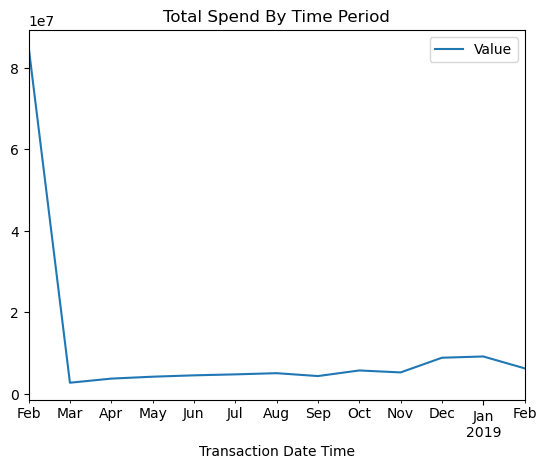

In [29]:
TestObject.plot("spend_by_period")
TestObject.spend_by_period()

,Total Count Of Active UserId,Total Count Of New Joiner UserId,Total Count Of Retained UserId
Transaction Date Time,,,
2018-02-01,857,857,0
2018-03-01,539,277,262
2018-04-01,844,427,417
2018-05-01,898,438,460
2018-06-01,1059,397,662
2018-07-01,1023,277,746
2018-08-01,1047,241,806
2018-09-01,980,190,790
2018-10-01,992,193,799


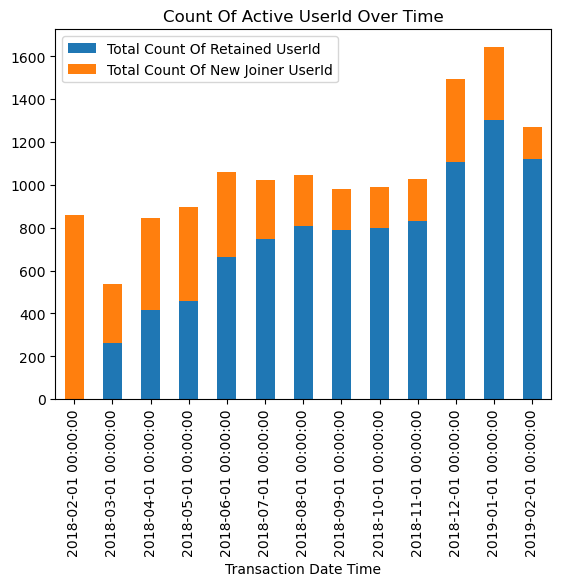

In [30]:
TestObject.plot("total_active_customers_by_period")
TestObject.total_active_customers_by_period()

Here we can ignore the first few periods as it is likely the dataset is just a continuation of previous year data so the "new" customers seen are not true new customers but just existing who haven't yet bought within the data sample period. However there is a trend that over time towards Q3/4 the no of new customers has reduced dramatically. 

Rather than just looking at the numbers within the context of the no of New vs Retained, a more important metric is the rate at which customers are leaving. This is what a Cohort chart shows where customers are grouped by a certain criteria and tracked over time to see how often they continue to transact after their first transaction

# 6.Cohort Analysis

The problem with using the Active Customer over time view is that at any given period, there will be a mix of customers who started transacting at different points of time. 
The custom object has a helpful function that pulls the earliest and the latest transaction date for each individual customer (NB : But only at Time Granularity set of course so it will default to Month Start in this scenario)

In [31]:
CustomerEarliestLatestTransaction=TestObject.customer_by_earliest_and_latest_transaction()
CustomerEarliestLatestTransaction

,UserId,CohortJoinPeriod,Last Recent Order Period
0,259266,2018-04-01,2018-04-01
1,259287,2018-04-01,2019-02-01
2,259308,2018-02-01,2018-12-01
3,259329,2019-02-01,2019-02-01
4,259350,2018-04-01,2018-04-01
...,...,...,...
4362,383880,2018-05-01,2018-05-01
4363,383901,2018-08-01,2018-08-01
4364,383922,2018-10-01,2019-02-01
4365,383943,2018-03-01,2019-02-01


# 6.1 Cohort Retention By Join Period By Time-Step

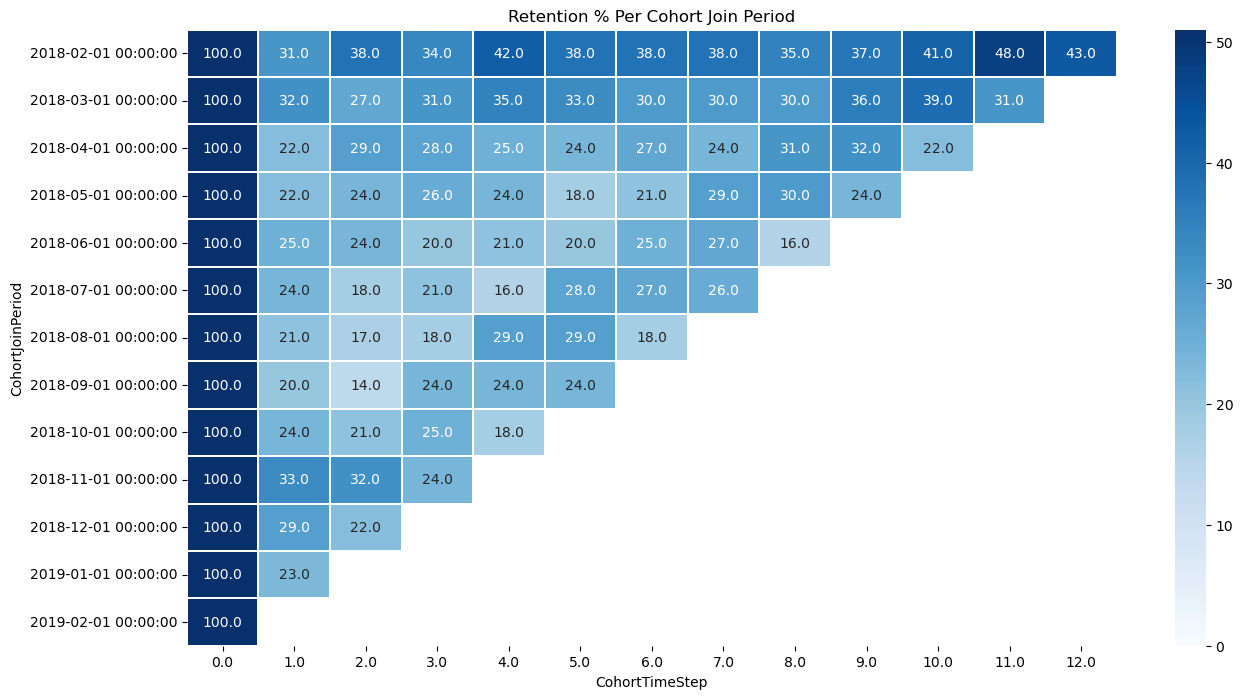

CohortTimeStep,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
CohortJoinPeriod,,,,,,,,,,,,,
2018-02-01,100.0,31.0,38.0,34.0,42.0,38.0,38.0,38.0,35.0,37.0,41.0,48.0,43.0
2018-03-01,100.0,32.0,27.0,31.0,35.0,33.0,30.0,30.0,30.0,36.0,39.0,31.0,NaN
2018-04-01,100.0,22.0,29.0,28.0,25.0,24.0,27.0,24.0,31.0,32.0,22.0,NaN,NaN
2018-05-01,100.0,22.0,24.0,26.0,24.0,18.0,21.0,29.0,30.0,24.0,NaN,NaN,NaN
2018-06-01,100.0,25.0,24.0,20.0,21.0,20.0,25.0,27.0,16.0,NaN,NaN,NaN,NaN
2018-07-01,100.0,24.0,18.0,21.0,16.0,28.0,27.0,26.0,NaN,NaN,NaN,NaN,NaN
2018-08-01,100.0,21.0,17.0,18.0,29.0,29.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-01,100.0,20.0,14.0,24.0,24.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-01,100.0,24.0,21.0,25.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
TestObject.plot("cohort_by_acquisition_period")
TestObject.cohort_by_acquisition_period()


In [33]:
#the same function can be called with an additional argument of "abs" to show absolute count of customers rather than % change
TestObject.cohort_by_acquisition_period("abs")

CohortTimeStep,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
CohortJoinPeriod,,,,,,,,,,,,,
2018-02-01,857.0,262.0,328.0,291.0,359.0,326.0,329.0,322.0,299.0,316.0,351.0,409.0,369.0
2018-03-01,277.0,89.0,76.0,86.0,96.0,92.0,82.0,83.0,84.0,101.0,108.0,86.0,NaN
2018-04-01,427.0,93.0,122.0,121.0,108.0,104.0,114.0,103.0,132.0,137.0,94.0,NaN,NaN
2018-05-01,438.0,95.0,105.0,115.0,103.0,81.0,93.0,129.0,131.0,103.0,NaN,NaN,NaN
2018-06-01,397.0,98.0,95.0,79.0,85.0,78.0,98.0,107.0,65.0,NaN,NaN,NaN,NaN
2018-07-01,277.0,67.0,49.0,57.0,43.0,78.0,75.0,71.0,NaN,NaN,NaN,NaN,NaN
2018-08-01,241.0,51.0,42.0,43.0,69.0,69.0,43.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-01,190.0,38.0,26.0,46.0,45.0,45.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-01,193.0,47.0,41.0,49.0,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The "spend" argument calculates the "absolute" total spend in dollar terms by the cohorts across time steps...

In [34]:
TestObject.cohort_by_acquisition_period("spend")

CohortTimeStep,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
CohortJoinPeriod,,,,,,,,,,,,,
2018-02-01,85158445.0,1263316.0,1802338.0,1769696.0,1894079.0,2093175.0,2068266.0,2026909.0,2463476.0,2400997.0,3152941.0,3564426.0,2533738.0
2018-03-01,1464451.0,496216.0,590783.0,632742.0,621413.0,919762.0,486891.0,978034.0,504384.0,1302800.0,1299203.0,685597.0,NaN
2018-04-01,1436152.0,281532.0,457226.0,448464.0,438281.0,436813.0,434910.0,494978.0,609947.0,709107.0,473427.0,NaN,NaN
2018-05-01,1563687.0,273854.0,398826.0,443170.0,321753.0,355253.0,414235.0,629135.0,542451.0,309611.0,NaN,NaN,NaN
2018-06-01,1280788.0,287875.0,301400.0,252980.0,314794.0,300046.0,373757.0,433893.0,204835.0,NaN,NaN,NaN,NaN
2018-07-01,928500.0,139429.0,172347.0,177718.0,117898.0,302699.0,259935.0,215627.0,NaN,NaN,NaN,NaN,NaN
2018-08-01,756190.0,58563.0,117723.0,130255.0,316269.0,236428.0,124787.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-01,606075.0,131742.0,67444.0,161112.0,166518.0,153042.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-01,763846.0,110481.0,132942.0,144992.0,90662.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 6.2 Cohort Retention By Customer Attribute By Time-Step

Although cohort by joining period provides a useful starting point, it may be more meaningful to analyse the customer transactional behaviors by the demographic characteristics which is what the next function does

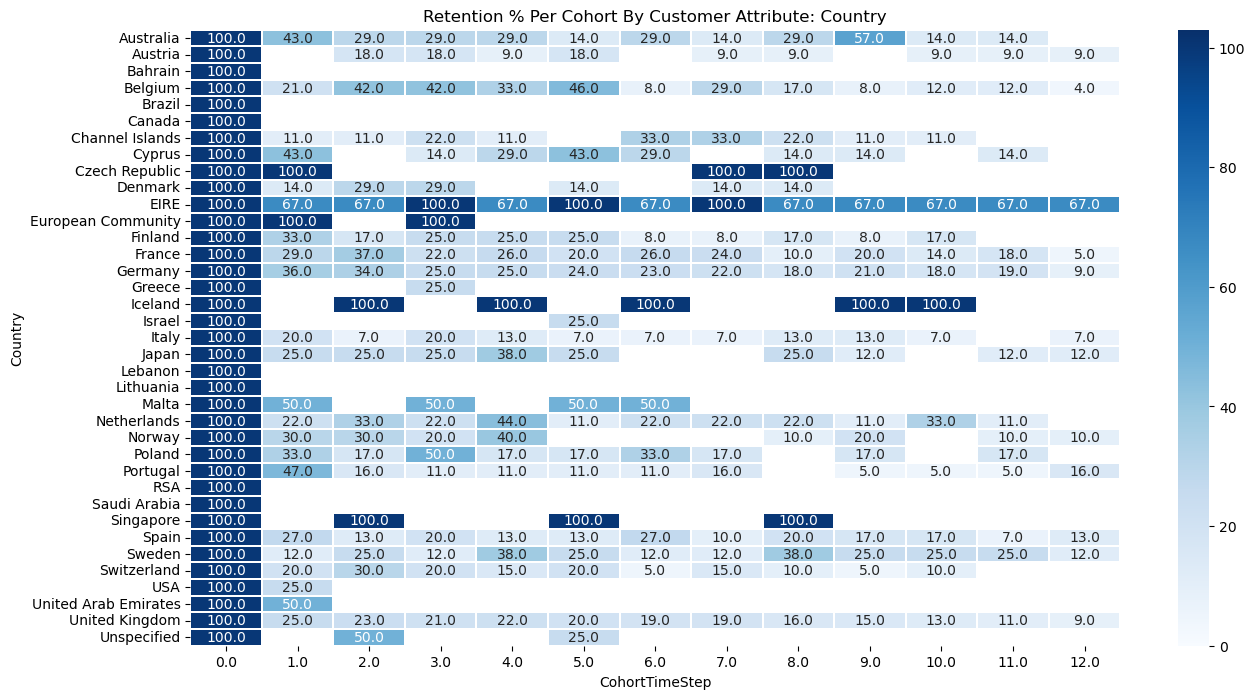

In [35]:
TestObject.plot("cohort_by_customer_attr",CustomerByCountry,"Country")

In [36]:
TestObject.cohort_by_customer_attr(CustomerByCountry,"Country")

CohortTimeStep,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
Country,,,,,,,,,,,,,
Australia,100.0,43.0,29.0,29.0,29.0,14.0,29.0,14.0,29.0,57.0,14.0,14.0,NaN
Austria,100.0,NaN,18.0,18.0,9.0,18.0,NaN,9.0,9.0,NaN,9.0,9.0,9.0
Bahrain,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Belgium,100.0,21.0,42.0,42.0,33.0,46.0,8.0,29.0,17.0,8.0,12.0,12.0,4.0
Brazil,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Canada,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Channel Islands,100.0,11.0,11.0,22.0,11.0,NaN,33.0,33.0,22.0,11.0,11.0,NaN,NaN
Cyprus,100.0,43.0,NaN,14.0,29.0,43.0,29.0,NaN,14.0,14.0,NaN,14.0,NaN
Czech Republic,100.0,100.0,NaN,NaN,NaN,NaN,NaN,100.0,100.0,NaN,NaN,NaN,NaN


Similarly as per before with cohort by acquisition period, the same table can be generated with absolute counts rather than percentages by appending the "abs" term

In [37]:
TestObject.cohort_by_customer_attr(CustomerByCountry,"Country","abs")

CohortTimeStep,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
Country,,,,,,,,,,,,,
Australia,7.0,3.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,4.0,1.0,1.0,NaN
Austria,11.0,NaN,2.0,2.0,1.0,2.0,NaN,1.0,1.0,NaN,1.0,1.0,1.0
Bahrain,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Belgium,24.0,5.0,10.0,10.0,8.0,11.0,2.0,7.0,4.0,2.0,3.0,3.0,1.0
Brazil,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Canada,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Channel Islands,9.0,1.0,1.0,2.0,1.0,NaN,3.0,3.0,2.0,1.0,1.0,NaN,NaN
Cyprus,7.0,3.0,NaN,1.0,2.0,3.0,2.0,NaN,1.0,1.0,NaN,1.0,NaN
Czech Republic,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN


# 6.3 Total Average Retention % By Time Step

Another useful overview is to view the aggregated behavior in a retention over time graph....

,Retained Customers By TimeStep,Retention Rate %
CohortTimeStep,,
0.0,4367.0,100.00
1.0,1095.0,25.07
2.0,1028.0,23.54
3.0,934.0,21.39
4.0,942.0,21.57
5.0,873.0,19.99
6.0,834.0,19.10
7.0,815.0,18.66
8.0,711.0,16.28


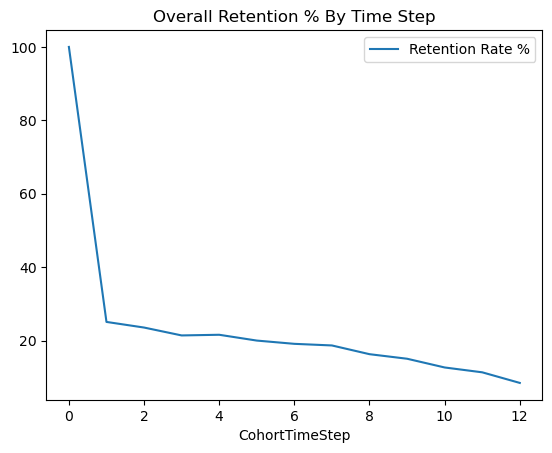

In [38]:
TestObject.plot("overall_retention_by_timestep")
TestObject.overall_retention_by_timestep()

# 6.4 Total No Of Customers By Cumulative Transaction Count

There is also a function that returns the count of customers by total transaction count and no of customers who have at least X transactions 

,Count Of Customers With Trx Freq = X,Count Of Customers With Trx Freq >=X
Frequency,,
1,1563,4367
2,911,2804
3,565,1893
4,386,1328
5,257,942
6,182,685
7,128,503
8,83,375
9,94,292


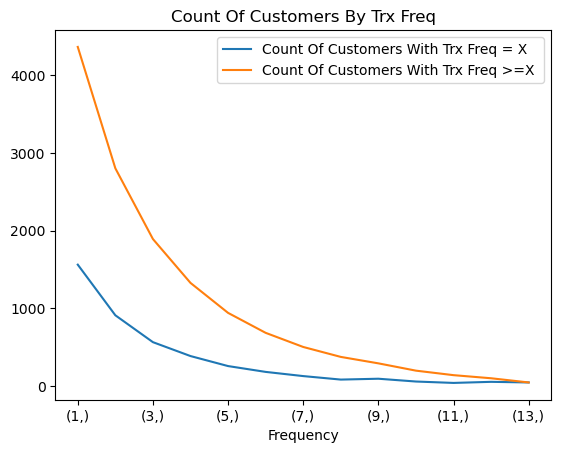

In [39]:
TestObject.plot("count_of_customers_by_min_trx_count")
TestObject.count_of_customers_by_min_trx_count()

# 6.5 Duration Between Transactions

,Mean Time Between Transactions In Months,10th Percentile In Months,Median In Months,90th Percentile In Months
Frequency,,,,
1,NaN,NaN,NaN,NaN
2,2.87,0.98,2.00,6.03
3,2.19,0.98,2.00,4.03
4,1.87,0.98,1.02,3.02
5,1.63,0.98,1.02,3.02
6,1.44,0.98,1.02,2.03
7,1.34,0.98,1.02,2.00
8,1.21,0.98,1.02,2.00
9,1.14,0.98,1.02,2.00


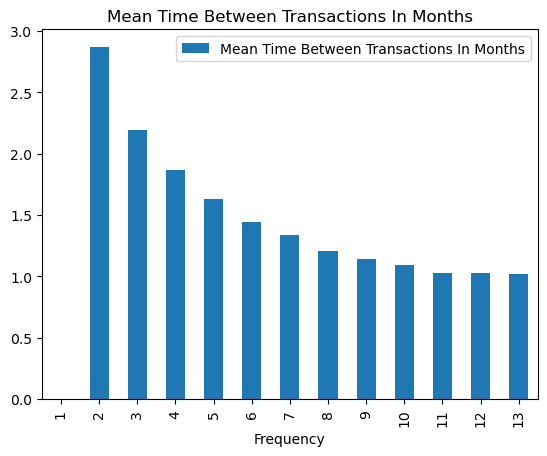

In [40]:
#This function provides the estimate of time between the transactions 
TestObject.plot("time_between_transactions")
TestObject.time_between_transactions()

# 6.6 Cohort Retention By Time-Step Using A Max Inactive Period Assumption

From the earlier Cohort Retention % by Join Period , it is clear that the steep drop in retention (the elbow) happens within the first month itself. Given that the data-set is limited (only 1 year) , a different approach to estimating retention that is less conservative is to focus on the last transaction only and assume that beyond a certain X threshold, the customer will have churned (ie max period of inactivity before churn estimate)

In [41]:
MaxInactivePeriod=30 #max period of inactivity since the latest/most recent transaction before customer is considered as "churned"

In [42]:
#This gives the Expiry Period upon which the above is built 
TestObject.cohort_by_acquisition_period_by_inactive_period(MaxInactivePeriod,"ExpiryDateByCustomer")

,UserId,CohortJoinPeriod,Last Recent Order Period,Customer Expiry Period
0,259266,2018-04-01,2018-04-01,2018-05-01
1,259287,2018-04-01,2019-02-01,2019-03-03
2,259308,2018-02-01,2018-12-01,2018-12-31
3,259329,2019-02-01,2019-02-01,2019-03-03
4,259350,2018-04-01,2018-04-01,2018-05-01
...,...,...,...,...
4362,383880,2018-05-01,2018-05-01,2018-05-31
4363,383901,2018-08-01,2018-08-01,2018-08-31
4364,383922,2018-10-01,2019-02-01,2019-03-03
4365,383943,2018-03-01,2019-02-01,2019-03-03


In [43]:
# IMPORTANT - this duration in Days will be limited by the granularity selected.... 
TestObject.cohort_by_acquisition_period_by_inactive_period(MaxInactivePeriod)

CohortTimeStep,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortJoinPeriod,,,,,,,,,,,,,
2018-02-01,100.0,100.0,86.0,86.0,83.0,83.0,79.0,77.0,77.0,72.0,72.0,61.0,43.0
2018-03-01,100.0,85.0,85.0,80.0,80.0,76.0,73.0,73.0,67.0,67.0,51.0,31.0,NaN
2018-04-01,100.0,100.0,74.0,74.0,69.0,67.0,67.0,60.0,60.0,41.0,22.0,NaN,NaN
2018-05-01,100.0,74.0,74.0,69.0,65.0,65.0,59.0,59.0,41.0,24.0,NaN,NaN,NaN
2018-06-01,100.0,100.0,67.0,62.0,62.0,54.0,54.0,35.0,16.0,NaN,NaN,NaN,NaN
2018-07-01,100.0,68.0,63.0,63.0,56.0,56.0,40.0,26.0,NaN,NaN,NaN,NaN,NaN
2018-08-01,100.0,66.0,66.0,54.0,54.0,38.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-01,100.0,100.0,52.0,52.0,39.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-01,100.0,52.0,52.0,35.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


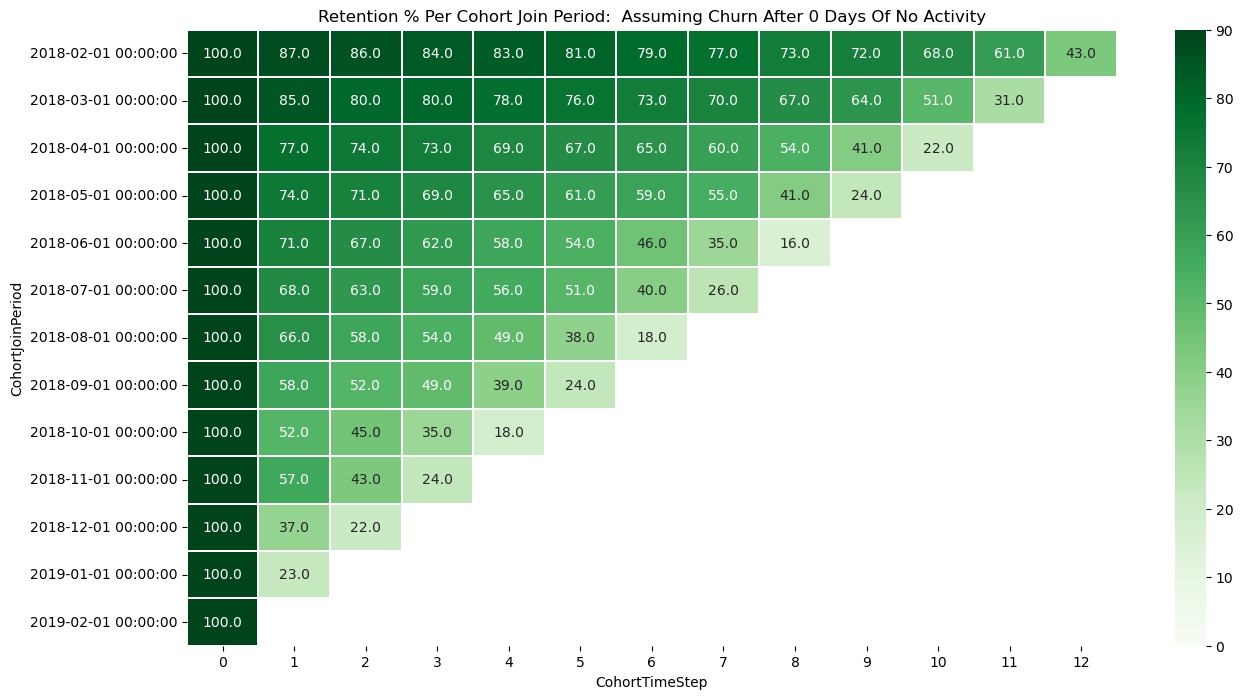

In [44]:
TestObject.plot("cohort_by_acquisition_period_by_inactive_period",MaxInactivePeriod)

In [45]:
TestObject.cohort_by_acquisition_period_by_inactive_period(MaxInactivePeriod,"abs")

CohortTimeStep,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortJoinPeriod,,,,,,,,,,,,,
2018-02-01,857.0,857.0,737.0,737.0,714.0,714.0,680.0,657.0,657.0,614.0,614.0,520.0,369.0
2018-03-01,277.0,236.0,236.0,221.0,221.0,211.0,201.0,201.0,185.0,185.0,141.0,86.0,NaN
2018-04-01,427.0,427.0,318.0,318.0,294.0,287.0,287.0,256.0,256.0,177.0,94.0,NaN,NaN
2018-05-01,438.0,323.0,323.0,302.0,284.0,284.0,260.0,260.0,181.0,103.0,NaN,NaN,NaN
2018-06-01,397.0,397.0,267.0,248.0,248.0,213.0,213.0,139.0,65.0,NaN,NaN,NaN,NaN
2018-07-01,277.0,188.0,174.0,174.0,154.0,154.0,112.0,71.0,NaN,NaN,NaN,NaN,NaN
2018-08-01,241.0,160.0,160.0,130.0,130.0,92.0,43.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-01,190.0,190.0,98.0,98.0,75.0,45.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-01,193.0,100.0,100.0,68.0,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Some judgement must be applied in interpreting the output above but it provides an alternative means to estimating retention

# 7. Recency, Frequency & Monetary RFM Analysis

Ultimately though ,the same data can be reflected in terms of Recency , Frequency and Monetary Value RFM Analysis but this works best with more granularity timescales (days vs mths)

In [46]:
#RFM typically works best with day level granularity

TestObjectInDays=CustRetAnalysisObj(InputTransactions,"TransactionId",
                  "SeqNo",
                  "UserId",
                  "Transaction Date Time",
                  "Value",
                  "d")

,Count Of Customers With Trx Freq = X,Count Of Customers With Trx Freq >=X
Frequency,,
1,1381,4367
2,858,2986
3,499,2128
4,386,1629
5,280,1243
6,194,963
7,154,769
8,110,615
9,69,505


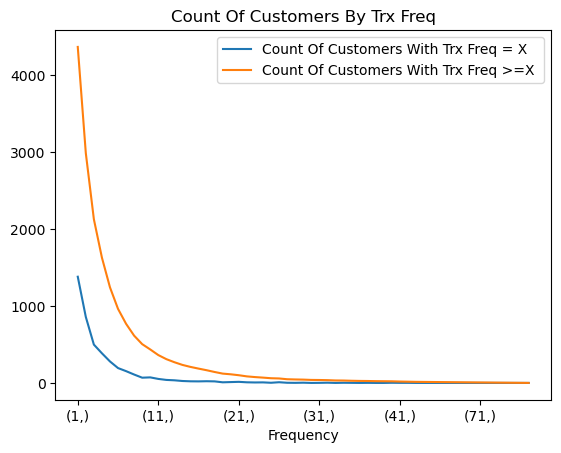

In [47]:
TestObjectInDays.plot("count_of_customers_by_min_trx_count")
TestObjectInDays.count_of_customers_by_min_trx_count()

,Mean Time Between Transactions In Days,10th Percentile In Days,Median In Days,90th Percentile In Days
Frequency,,,,
1,NaN,NaN,NaN,NaN
2,68.79,5.0,40.0,177.0
3,54.02,5.0,37.0,125.0
4,45.30,5.0,31.0,104.0
5,38.59,5.0,29.0,88.0
...,...,...,...,...
142,1.00,1.0,1.0,1.0
143,3.00,3.0,3.0,3.0
144,1.00,1.0,1.0,1.0


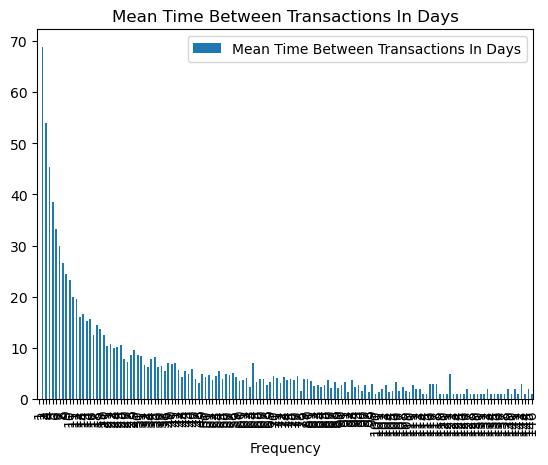

In [48]:
TestObjectInDays.plot("time_between_transactions")
TestObjectInDays.time_between_transactions()

In [49]:
RFM_table=TestObjectInDays.create_RFM_Table()
RFM_table

,UserId,Frequency,Frequency Minus 1,Recency In Days,Age In Days,Earliest Order,Most Recent Order,Total Monetary Value,First Time Purchase Value,Average Time Between Orders In Days,Average Monetary Value Per Days
1893,313131,146,145,372.0,373.0,2018-02-12,2019-02-19,1100086.32,4607.04,2.57,7555.03
330,267708,114,113,373.0,373.0,2018-02-12,2019-02-20,238793.34,41.04,3.30,2112.85
4038,374661,113,112,372.0,373.0,2018-02-12,2019-02-19,334683.72,4424.04,3.33,2948.75
2189,321531,91,90,373.0,373.0,2018-02-12,2019-02-20,493483.20,3694.56,4.14,5442.10
1672,306726,89,88,372.0,373.0,2018-02-12,2019-02-19,97172.10,1646.10,4.24,1085.52
...,...,...,...,...,...,...,...,...,...,...,...
1079,289800,1,0,0.0,309.0,2018-04-17,2018-04-17,4633.56,4633.56,0.00,0.00
1080,289821,1,0,0.0,66.0,2018-12-16,2018-12-16,2694.60,2694.60,0.00,0.00
2934,342783,1,0,0.0,196.0,2018-08-08,2018-08-08,1719.00,1719.00,0.00,0.00
1082,289863,1,0,0.0,255.0,2018-06-10,2018-06-10,2298.72,2298.72,0.00,0.00


,Average
Recency In Days,133.03
Frequency,4.40
Average Time Between Orders In Days,73.23
Average Monetary Value Per Days,1768.71


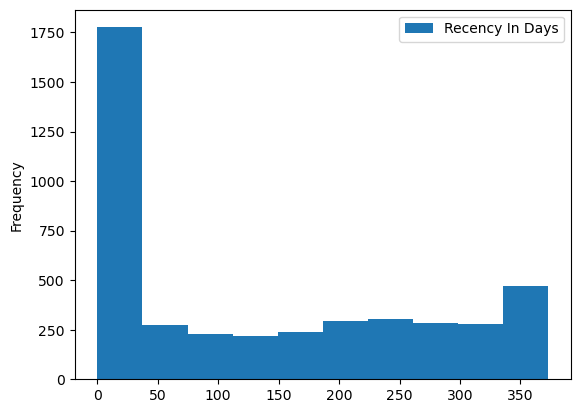

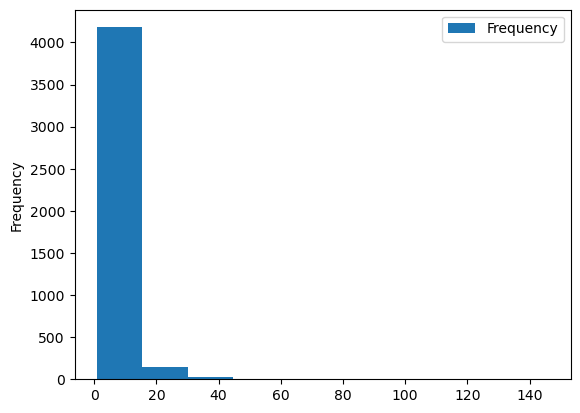

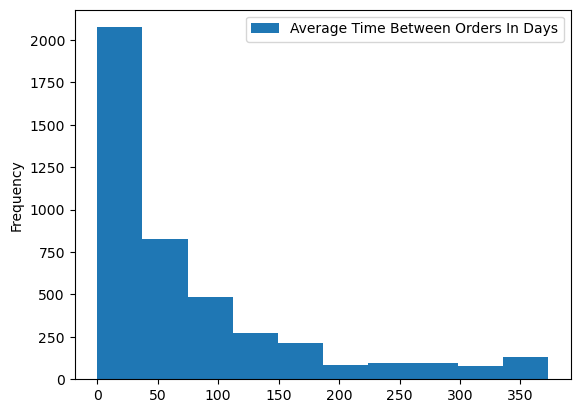

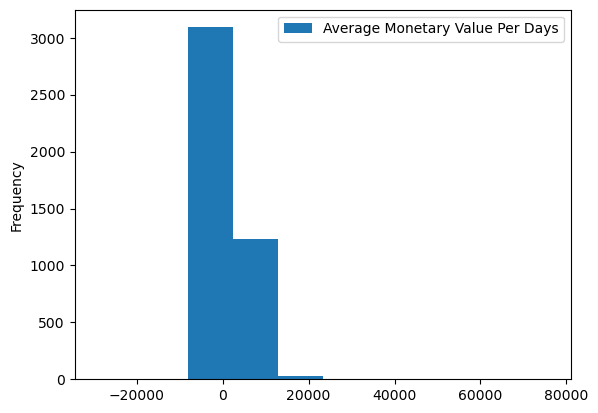

In [50]:
TestObjectInDays.plot("RFM_summary")